# AutoML Image Classification 1H Challenge: Added Noise (Digits)

![](imgs/gaussian_noise.png)

In [1]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/wrk/users/thalvari/dpEmu-AutoML/venv

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [2]:
def get_data():
    random_state = RandomState(42)
    digits = load_digits()
    return train_test_split(digits["data"], digits["target"], test_size=.2, random_state=random_state)

In [3]:
def get_err_root_node():
    err_img_node = Array(reshape=(8, 8))
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(GaussianNoise("mean", "std"))
    err_img_node.addfilter(Clip("min_val", "max_val"))
    return err_root_node

In [4]:
def get_err_params_list(data):
    min_val = np.amin(data)
    max_val = np.amax(data)
    std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    return err_params_list

In [5]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return train_data, test_data, {}

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*1
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        return {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}")
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s)).astype(np.uint8)
        x_train = x_train.reshape(x_train.shape + (1,))
        y_train = y_train.astype(np.uint8)
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s)).astype(np.uint8)
        x = x.reshape(x.shape + (1,))
        y = y.astype(np.uint8)
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [7]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        {
            "model": AutoKerasModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": True
        },
    ]

In [8]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [9]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
)

  0%|          | 0/6 [00:00<?, ?it/s]

Checking whether there is an H2O instance running at http://localhost:54321 

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

Checking whether there is an H2O instance running at http://localhost:54321 

Checking whether there is an H2O instance running at http://localhost:54321 

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

 not found.

 not found.

 not found.

Attempting to start a local H2O server...

 not found.

Attempting to start a local H2O server...

 not found.

Attempting to start a local H2O server...

Attempting to start a local H2O server...

Attempting to start a local H2O server...

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpkxf3tj_w

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Ice root: /wrk/users/thalvari/tmp1_zzhv94

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  JVM stdout: /wrk/users/thalvari/tmpkxf3tj_w/h2o_thalvari_started_from_python.out

  JVM stdout: /wrk/users/thalvari/tmp1_zzhv94/h2o_thalvari_started_from_python.out

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Ice root: /wrk/users/thalvari/tmpikdh6cfx

  Ice root: /wrk/users/thalvari/tmplqkjnkid

  JVM stderr: /wrk/users/thalvari/tmpkxf3tj_w/h2o_thalvari_started_from_python.err

  JVM stderr: /wrk/users/thalvari/tmp1_zzhv94/h2o_thalvari_started_from_python.err

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpsim7kbdg

  JVM stdout: /wrk/users/thalvari/tmpikdh6cfx/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpikdh6cfx/h2o_thalvari_started_from_python.err

  JVM stdout: /wrk/users/thalvari/tmplqkjnkid/h2o_thalvari_started_from_python.out

  JVM stdout: /wrk/users/thalvari/tmpsim7kbdg/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmplqkjnkid/h2o_thalvari_started_from_python.err

  JVM stderr: /wrk/users/thalvari/tmpsim7kbdg/h2o_thalvari_started_from_python.err

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpak2s80kz

  JVM stdout: /wrk/users/thalvari/tmpak2s80kz/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpak2s80kz/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54331

  Server is running at http://127.0.0.1:54325

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54331 ..

.

Connecting to H2O server at http://127.0.0.1:54325 ..

Connecting to H2O server at http://127.0.0.1:54321 ..

  Server is running at http://127.0.0.1:54327

.

  Server is running at http://127.0.0.1:54323

.

Connecting to H2O server at http://127.0.0.1:54327 ..

Connecting to H2O server at http://127.0.0.1:54323 ..

.

.

  Server is running at http://127.0.0.1:54329

Connecting to H2O server at http://127.0.0.1:54329 ..

.

 successful.

 successful.

 successful.

 successful.

 successful.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#337309899
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#667901170
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#915618796
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#1018648931
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#16613927
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#623205616
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_9445 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp1_4ofhtr

  JVM stdout: /wrk/users/thalvari/tmp1_4ofhtr/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp1_4ofhtr/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54323

Connecting to H2O server at http://127.0.0.1:54323 ..

.

 successful.

H2O cluster uptime:,06 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#624438180
H2O cluster total nodes:,1
H2O cluster free memory:,26.56 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b862 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpj9w3cct8

  JVM stdout: /wrk/users/thalvari/tmpj9w3cct8/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpj9w3cct8/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,05 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#974492840
H2O cluster total nodes:,1
H2O cluster free memory:,26.64 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_aa2c closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpkow2b4hh

  JVM stdout: /wrk/users/thalvari/tmpkow2b4hh/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpkow2b4hh/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54333

Connecting to H2O server at http://127.0.0.1:54333 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#176891253
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_93d1 closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp8bmqgo1o

  JVM stdout: /wrk/users/thalvari/tmp8bmqgo1o/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp8bmqgo1o/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54325

Connecting to H2O server at http://127.0.0.1:54325 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#852886713
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b93d closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpyowffev3

  JVM stdout: /wrk/users/thalvari/tmpyowffev3/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpyowffev3/h2o_thalvari_started_from_python.err

H2O session _sid_9f7a closed.

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

  Server is running at http://127.0.0.1:54329

Connecting to H2O server at http://127.0.0.1:54329 ..

.

 not found.

 successful.

Attempting to start a local H2O server...

  Java Version: openjdk version "1.8.0_222"; OpenJDK Runtime Environment (build 1.8.0_222-b10); OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpy0ex4egw

  JVM stdout: /wrk/users/thalvari/tmpy0ex4egw/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpy0ex4egw/h2o_thalvari_started_from_python.err

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#872243059
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


  Server is running at http://127.0.0.1:54327

Connecting to H2O server at http://127.0.0.1:54327 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.8
H2O cluster version age:,4 days
H2O cluster name:,#128086894
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,18
H2O cluster allowed cores:,18
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8e97 closed.

H2O session _sid_af56 closed.

H2O session _sid_8c16 closed.

H2O session _sid_9ee0 closed.

H2O session _sid_85ed closed.

H2O session _sid_9a0b closed.

60.39065195 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GaussianNB(SelectPercentile(CombineDFs(XGBClassifier(CombineDFs(input_matrix, input_matrix), learning_rate=0.001, max_depth=2, min_child_weight=5, n_estimators=100, nthread=1, subsample=0.15000000000000002), input_matrix), percentile=64))

/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


/wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/sklearn/preprocessing/_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


62.11362418333333 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(OneHotEncoder(SelectFwe(XGBClassifier(input_matrix, learning_rate=0.5, max_depth=8, min_child_weight=15, n_estimators=100, nthread=1, subsample=0.45), alpha=0.045), minimum_fraction=0.05, sparse=False, threshold=10), C=0.0001, dual=False, penalty=l2)

60.293992249999995 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MultinomialNB(SelectFwe(input_matrix, alpha=0.019), alpha=10.0, fit_prior=False), n_neighbors=42, p=2, weights=distance)

61.269447883333335 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

60.56287721666667 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MinMaxScaler(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.9000000000000001, min_samples_leaf=6, min_samples_split=8, n_estimators=100)), n_neighbors=1, p=2, weights=distance)

Best pipeline:

LogisticRegression(DecisionTreeClassifier(RFE(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), criterion=entropy, max_features=0.6000000000000001, n_estimators=100, step=0.6000000000000001), criterion=gini, max_depth=4, min_samples_leaf=17, min_samples_split=5), C=0.001, dual=True, penalty=l2)

64.07756483333334 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(SelectFwe(input_matrix, alpha=0.035), C=0.0001, dual=True, penalty=l2)

61.0124247 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(ZeroCount(OneHotEncoder(input_matrix, minimum_fraction=0.1, sparse=False, threshold=10)), bootstrap=False, criterion=entropy, max_features=0.6500000000000001, min_samples_leaf=2, min_samples_split=13, n_estimators=100), n_neighbors=4, p=2, weights=distance)

60.282561099999995 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=gini, max_features=0.9000000000000001, min_samples_leaf=6, min_samples_split=8, n_estimators=100), n_neighbors=1, p=2, weights=uniform)

61.284871433333336 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=False, criterion=gini, max_features=0.9000000000000001, min_samples_leaf=6, min_samples_split=8, n_estimators=100), n_neighbors=1, p=2, weights=uniform)

64.91257811666667 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(ZeroCount(OneHotEncoder(input_matrix, minimum_fraction=0.1, sparse=False, threshold=10)), bootstrap=False, criterion=entropy, max_features=0.6500000000000001, min_samples_leaf=2, min_samples_split=13, n_estimators=100), n_neighbors=4, p=2, weights=distance)

65.97045243333334 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(ExtraTreesClassifier(ZeroCount(OneHotEncoder(input_matrix, minimum_fraction=0.1, sparse=False, threshold=10)), bootstrap=False, criterion=entropy, max_features=0.6500000000000001, min_samples_leaf=2, min_samples_split=13, n_estimators=100), n_neighbors=4, p=2, weights=distance)

63.42187465 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(MinMaxScaler(ExtraTreesClassifier(input_matrix, bootstrap=False, criterion=gini, max_features=0.9000000000000001, min_samples_leaf=6, min_samples_split=8, n_estimators=100)), n_neighbors=1, p=2, weights=distance)

 17%|█▋        | 1/6 [5:58:39<29:53:19, 21519.94s/it]

 50%|█████     | 3/6 [6:01:49<12:34:37, 15092.43s/it]

 67%|██████▋   | 4/6 [6:05:05<5:54:06, 10623.33s/it] 

 83%|████████▎ | 5/6 [6:05:14<2:03:59, 7439.11s/it] 

100%|██████████| 6/6 [6:05:14<00:00, 3652.41s/it]  

'AutoKeras #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.983,0.995,0.161,0,3603.39
3.2,0.939,0.987,0.204,0,3603.42
6.4,0.711,0.871,0.158,0,3623.05
9.6,0.4,0.949,0.135,0,3693.42
12.8,0.206,0.939,0.134,0,3789.15
16,0.167,0.924,0.151,0,3705.72


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75
0,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3.2,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6.4,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
9.6,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

'AutoKerasClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.983,0.995,0.161,0,3601.97
3.2,0.917,0.995,0.204,0,3603.84
6.4,0.622,0.995,0.158,0,3602.22
9.6,0.344,0.995,0.135,0,3601.88
12.8,0.256,0.995,0.134,0,3602.09
16,0.192,0.995,0.151,0,3604.43


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16
0,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)"
3.2,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)"
6.4,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)"
9.6,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)"
12.8,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

'H2OAutoML #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.983,1,0.161,0,3488.91
3.2,0.967,1,0.204,0,3479.22
6.4,0.858,1,0.158,0,3491.84
9.6,0.622,1,0.135,0,3389.12
12.8,0.494,0.553,0.134,0,3030.59
16,0.417,0.467,0.151,0,2747.31


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99,pipe_100,pipe_101,pipe_102,pipe_103,pipe_104
0,StackedEnsemble_AllModels_AutoML_20191023_002526,DeepLearning_grid_1_AutoML_20191023_002526_model_8,DeepLearning_grid_1_AutoML_20191023_002526_model_2,GBM_grid_1_AutoML_20191023_002526_model_40,GBM_grid_1_AutoML_20191023_002526_model_31,GBM_grid_1_AutoML_20191023_002526_model_18,DeepLearning_grid_1_AutoML_20191023_002526_model_1,GBM_grid_1_AutoML_20191023_002526_model_39,GBM_grid_1_AutoML_20191023_002526_model_19,DeepLearning_grid_1_AutoML_20191023_002526_model_12,DeepLearning_grid_1_AutoML_20191023_002526_model_11,GBM_grid_1_AutoML_20191023_002526_model_41,XGBoost_grid_1_AutoML_20191023_002526_model_13,DeepLearning_grid_1_AutoML_20191023_002526_model_7,DeepLearning_grid_1_AutoML_20191023_002526_model_3,GBM_grid_1_AutoML_20191023_002526_model_15,GBM_grid_1_AutoML_20191023_002526_model_35,GBM_2_AutoML_20191023_002526,GBM_grid_1_AutoML_20191023_002526_model_3,GBM_3_AutoML_20191023_002526,GBM_grid_1_AutoML_20191023_002526_model_32,GBM_grid_1_AutoML_20191023_002526_model_26,GBM_grid_1_AutoML_20191023_002526_model_6,GBM_grid_1_AutoML_20191023_002526_model_27,GBM_grid_1_AutoML_20191023_002526_model_20,GBM_5_AutoML_20191023_002526,GBM_grid_1_AutoML_20191023_002526_model_12,DeepLearning_grid_1_AutoML_20191023_002526_model_5,GBM_4_AutoML_20191023_002526,DeepLearning_grid_1_AutoML_20191023_002526_model_4,GLM_grid_1_AutoML_20191023_002526_model_1,GBM_grid_1_AutoML_20191023_002526_model_17,XRT_1_AutoML_20191023_002526,GBM_grid_1_AutoML_20191023_002526_model_1,GBM_grid_1_AutoML_20191023_002526_model_10,XGBoost_grid_1_AutoML_20191023_002526_model_8,GBM_1_AutoML_20191023_002526,GBM_grid_1_AutoML_20191023_002526_model_42,GBM_grid_1_AutoML_20191023_002526_model_14,GBM_grid_1_AutoML_20191023_002526_model_11,XGBoost_grid_1_AutoML_20191023_002526_model_30,GBM_grid_1_AutoML_20191023_002526_model_16,DeepLearning_grid_1_AutoML_20191023_002526_model_6,GBM_grid_1_AutoML_20191023_002526_model_24,DRF_1_AutoML_20191023_002526,XGBoost_grid_1_AutoML_20191023_002526_model_17,GBM_grid_1_AutoML_20191023_002526_model_13,XGBoost_3_AutoML_20191023_002526,XGBoost_1_AutoML_20191023_002526,XGBoost_grid_1_AutoML_20191023_002526_model_25,XGBoost_grid_1_AutoML_20191023_002526_model_21,XGBoost_grid_1_AutoML_20191023_002526_model_18,XGBoost_grid_1_AutoML_20191023_002526_model_26,XGBoost_grid_1_AutoML_20191023_002526_model_15,GBM_grid_1_AutoML_20191023_002526_model_43,GBM_grid_1_AutoML_20191023_002526_model_8,GBM_grid_1_AutoML_20191023_002526_model_9,XGBoost_grid_1_AutoML_20191023_002526_model_20,XGBoost_grid_1_AutoML_20191023_002526_model_27,XGBoost_grid_1_AutoML_20191023_002526_model_4,XGBoost_grid_1_AutoML_20191023_002526_model_31,DeepLearning_grid_1_AutoML_20191023_002526_model_9,XGBoost_grid_1_AutoML_20191023_002526_model_2,DeepLearning_grid_1_AutoML_20191023_002526_model_13,GBM_grid_1_AutoML_20191023_002526_model_29,XGBoost_grid_1_AutoML_20191023_002526_model_29,GBM_grid_1_AutoML_20191023_002526_model_28,XGBoost_grid_1_AutoML_20191023_002526_model_33,XGBoost_grid_1_AutoML_20191023_002526_model_28,DeepLearning_grid_1_AutoML_20191023_002526_model_10,XGBoost_grid_1_AutoML_20191023_002526_model_3,XGBoost_grid_1_AutoML_20191023_002526_model_32,X

'H2OAutoMLClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.986,1,0.161,0,3508.12
3.2,0.2,1,0.204,0,3447.04
6.4,0.664,1,0.158,0,3468.89
9.6,0.525,1,0.135,0,3558.44
12.8,0.378,1,0.134,0,3780.19
16,0.294,1,0.151,0,3988.69


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75,pipe_76,pipe_77,pipe_78,pipe_79,pipe_80,pipe_81,pipe_82,pipe_83,pipe_84,pipe_85,pipe_86,pipe_87,pipe_88,pipe_89,pipe_90,pipe_91,pipe_92,pipe_93,pipe_94,pipe_95,pipe_96,pipe_97,pipe_98,pipe_99,pipe_100,pipe_101,pipe_102,pipe_103,pipe_104,pipe_105,pipe_106,pipe_107,pipe_108,pipe_109,pipe_110,pipe_111,pipe_112,pipe_113,pipe_114,pipe_115,pipe_116,pipe_117,pipe_118,pipe_119,pipe_120,pipe_121,pipe_122,pipe_123,pipe_124,pipe_125,pipe_126,pipe_127,pipe_128,pipe_129,pipe_130,pipe_131
0,StackedEnsemble_AllModels_AutoML_20191023_012335,DeepLearning_grid_1_AutoML_20191023_012335_model_12,GBM_grid_1_AutoML_20191023_012335_model_40,GBM_grid_1_AutoML_20191023_012335_model_31,DeepLearning_grid_1_AutoML_20191023_012335_model_2,GBM_grid_1_AutoML_20191023_012335_model_18,DeepLearning_grid_1_AutoML_20191023_012335_model_7,DeepLearning_grid_1_AutoML_20191023_012335_model_8,GBM_grid_1_AutoML_20191023_012335_model_39,GBM_grid_1_AutoML_20191023_012335_model_19,GBM_grid_1_AutoML_20191023_012335_model_41,XGBoost_grid_1_AutoML_20191023_012335_model_13,DeepLearning_grid_1_AutoML_20191023_012335_model_3,GBM_grid_1_AutoML_20191023_012335_model_15,GBM_grid_1_AutoML_20191023_012335_model_35,GBM_2_AutoML_20191023_012335,GBM_grid_1_AutoML_20191023_012335_model_43,DeepLearning_grid_1_AutoML_20191023_012335_model_1,DeepLearning_grid_1_AutoML_20191023_012335_model_11,GBM_grid_1_AutoML_20191023_012335_model_3,GBM_3_AutoML_20191023_012335,GBM_grid_1_AutoML_20191023_012335_model_32,GBM_grid_1_AutoML_20191023_012335_model_26,GBM_grid_1_AutoML_20191023_012335_model_6,GBM_grid_1_AutoML_20191023_012335_model_27,GBM_grid_1_AutoML_20191023_012335_model_20,DeepLearning_grid_1_AutoML_20191023_012335_model_6,DeepLearning_grid_1_AutoML_20191023_012335_model_5,GBM_5_AutoML_20191023_012335,XGBoost_grid_1_AutoML_20191023_012335_model_33,GBM_grid_1_AutoML_20191023_012335_model_12,DeepLearning_grid_1_AutoML_20191023_012335_model_9,DeepLearning_grid_1_AutoML_20191023_012335_model_4,GBM_4_AutoML_20191023_012335,GLM_grid_1_AutoML_20191023_012335_model_1,GBM_grid_1_AutoML_20191023_012335_model_17,XGBoost_grid_1_AutoML_20191023_012335_model_35,XRT_1_AutoML_20191023_012335,GBM_grid_1_AutoML_20191023_012335_model_1,GBM_grid_1_AutoML_20191023_012335_model_10,XGBoost_grid_1_AutoML_20191023_012335_model_8,GBM_1_AutoML_20191023_012335,GBM_grid_1_AutoML_20191023_012335_model_14,GBM_grid_1_AutoML_20191023_012335_model_42,GBM_grid_1_AutoML_20191023_012335_model_11,XGBoost_grid_1_AutoML_20191023_012335_model_30,GBM_grid_1_AutoML_20191023_012335_model_16,GBM_grid_1_AutoML_20191023_012335_model_24,DRF_1_AutoML_20191023_012335,XGBoost_grid_1_AutoML_20191023_012335_model_17,GBM_grid_1_AutoML_20191023_012335_model_13,XGBoost_3_AutoML_20191023_012335,XGBoost_1_AutoML_20191023_012335,GBM_grid_1_AutoML_20191023_012335_model_45,XGBoost_grid_1_AutoML_20191023_012335_model_25,XGBoost_grid_1_AutoML_20191023_012335_model_21,XGBoost_grid_1_AutoML_20191023_012335_model_18,XGBoost_grid_1_AutoML_20191023_012335_model_26,XGBoost_grid_1_AutoML_20191023_012335_model_15,GBM_grid_1_AutoML_20191023_012335_model_8,GBM_grid_1_AutoML_20191023_012335_model_9,XGBoost_grid_1_AutoML_20191023_012335_model_20,XGBoost_grid_1_AutoML_20191023_012335_model_27,XGBoost_grid_1_AutoML_20191023_012335_model_34,XGBoost_grid_1_AutoML_20191023_012335_model_4,XGBoost_grid_1_AutoML_20191023_012335_model_31,XGBoost_grid_1_AutoML_20191023_012335_model_

'TPOTClassifier #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.981,1,0.161,0,3636.14
3.2,0.978,1,0.204,0,3746.28
6.4,0.831,1,0.158,0,3620.16
9.6,0.644,0.666,0.135,0,3845.61
12.8,0.508,0.537,0.134,0,3733.86
16,0.4,0.459,0.151,0,3630


std,pipe_0,pipe_1,pipe_2,pipe_3
0,"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.9000000000000001, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=6, min_samples_split=8, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","MinMaxScaler(copy=True, feature_range=(0, 1))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=1, p=2, weights='distance')",nan
3.2,"PolynomialFeatures(degree=2, include_bias=False, interaction_only=False, order='C')","RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.6000000000000001, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False), n_features_to_select=None, step=0.6000000000000001, verbose=0)","StackingEstimator(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=17, min_samples_split=5, min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best'))","LogisticRegression(C=0.001, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)"
6.4,"SelectFwe(alpha=0.019, score_func=)","StackingEstimator(estimator=MultinomialNB(alpha=10.0, class_prior=None, fit_prior=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=42, p=2, weights='distance')",nan
9.6,"SelectFwe(alpha=0.035, score_func=)","LogisticRegression(C=0.0001, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan,nan
12.8,"StackingEstimator(estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0, max_depth=8, min_child_weight=15, missing=nan, n_estimators=100, n_jobs=1, nthread=1, objective='multi:softprob', random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.45, verbosity=1))","SelectFwe(alpha=0.045, score_func=)","OneHotEncoder(categorical_features=[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, ...], dtype=, minimum_fraction=0.05, sparse=False, threshold=10)","LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l2', random_state=None, solver='warn', tol=0.0001, verbose=0, warm_start=False)"
16,"FeatureUnion(n_jobs=None, transformer_list=[('stackingestimator', StackingEstimator(estimator=Pipeline(memory=None, steps=[('featureunion', FeatureUnion(n_jobs=None, transformer_list=[('functiontransformer-1', FunctionTransformer(accept_sparse=False, check_inverse=True, func=, inv_kw_args=None, inverse_func=None, kw_args=None, pas... reg_lambda=1, scale_pos_weight=1, seed=None, silent=None, subsample=0.15000000000000002, verbosity=1))], verbose=False))), ('functiontransformer', FunctionTransformer(accept_sparse=False, check_inverse=True, func=, inv_kw_args=None, inverse_func=None, kw_args=None, pass_y='deprecated', validate=None))], tra

'TPOTClassifierClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.981,1,0.161,0,3681.11
3.2,0.978,1,0.204,0,3621.03
6.4,0.9,1,0.158,0,3903.24
9.6,0.244,1,0.135,0,3816.25
12.8,0.514,1,0.134,0,3978.28
16,0.378,1,0.151,0,3664.35


std,pipe_0,pipe_1,pipe_2,pipe_3
0,ZeroCount(),"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.9000000000000001, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=6, min_samples_split=8, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=1, p=2, weights='uniform')",nan
3.2,ZeroCount(),"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.9000000000000001, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=6, min_samples_split=8, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=1, p=2, weights='uniform')",nan
6.4,"OneHotEncoder(categorical_features=[True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, True, False, False, False, False, False, ...], dtype=, minimum_fraction=0.1, sparse=False, threshold=10)",ZeroCount(),"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.6500000000000001, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=2, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
9.6,"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.9000000000000001, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=6, min_samples_split=8, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","MinMaxScaler(copy=True, feature_range=(0, 1))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=1, p=2, weights='distance')",nan
12.8,"OneHotEncoder(categorical_features=[True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, True, False, False, False, False, False, ...], dtype=, minimum_fraction=0.1, sparse=False, threshold=10)",ZeroCount(),"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.6500000000000001, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=2, min_samples_split=13, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=4, p=2, weights='distance')"
16,"OneHotEncoder(categorical_features=[True, True, False, False, False, False, False, False, True, False, False, False, False, False, False, False, True, False, False, False, False, False, False, True, True, False, False, False, False, False, ...], dtype=, minimum_fraction=0.1, sparse=False, threshold=10)",ZeroCount(),"StackingEstimator(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy', max_depth=None, max_features=0.6500000000000001, max_leaf_nodes=None, min_impuri

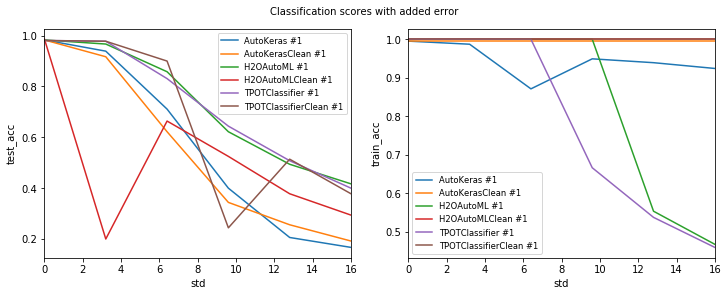

In [10]:
print_results_by_model(df,
    ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)